# Predicting Credit Risk for Loan Applicants

**Dataset:** [German Credit dataset (Kaggle)](https://www.kaggle.com/datasets/uciml/german-credit)

---

## 1. Problem Statement  
Financial institutions face significant challenges in assessing the creditworthiness of loan applicants. The goal of this project is to build a model that classifies each applicant as either a **good credit risk** or a **bad credit risk**, minimizing defaults and helping lenders make informed decisions.

---

## 2. Background  
The German Credit dataset contains 1,000 records with 20 attributes covering applicants’ financial history, personal information, and loan details. It’s widely used for benchmarking classification algorithms in credit-scoring research.

---

## 3. Objective  
- **Primary:** Develop a machine learning classifier to predict credit risk (good vs. bad).  
- **Secondary:**  
  - Identify and interpret the most influential features.  
  - Propose actionable strategies to enhance the credit evaluation process.

---

In [21]:
# Import Block
import warnings 
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.io as pio
import plotly.tools as tls
import plotly.offline as py 
import plotly.express as px
import plotly.graph_objs as go 
from collections import Counter 
import matplotlib.pyplot as plt 

### Custom Theme & Config

In [23]:
# Display Max columns
pd.pandas.set_option("display.max_columns", None)

# Dark Mode of Ploty
pio.templates.default = "plotly_dark"

# Dark Mode
sns.set_theme(
    style='dark',
    rc={
        'figure.facecolor': 'black',
        'axes.facecolor':   'black',
        'axes.edgecolor':   'white',
        'savefig.facecolor':'black',
        'text.color':       'white',
        'axes.labelcolor':  'white',
        'xtick.color':      'white',
        'ytick.color':      'white' 
    }
)

plt.rcParams.update({
    'figure.facecolor': 'black',
    'axes.facecolor':   'black',
    'axes.edgecolor':   'white',
    'savefig.facecolor':'black',
    'text.color':       'white',
    'axes.labelcolor':  'white',
    'xtick.color':      'white',
    'ytick.color':      'white',
    'grid.color':       'gray',
})

In [3]:
df = pd.read_csv("../data/raw/german_credit_data.csv")

## 1. **Data Overview**
A foundational understanding of the dataset.
- Dimensions of the dataset
- Data types and null counts for each column
- Number of unique values per column
- Basic statistical summary of numeric features
- Preview of the first few rows of the dataset

In [14]:
# ------------------------------------------------------------
# 1. Data Overview
#    Provide a dimensional understanding of the dataset
# ------------------------------------------------------------
print("_" * 120)
print(f"DIMENSIONS OF DATASET: {df.shape}")  # rows and columns
print("_" * 120)


# ------------------------------------------------------------
# 2. Feature Information
#    Display data types and non-null counts for each column
# ------------------------------------------------------------
print("FEATURE INFO:")
df.info()
print("_" * 120)


# ------------------------------------------------------------
# 3. Unique Value Counts
#    Show number of distinct entries per column
# ------------------------------------------------------------
print("UNIQUE VALUE COUNTS:")
print(df.nunique())
print("_" * 120)


# ------------------------------------------------------------
# 4. Basic Statistical Summary
#    Summary of numeric columns (mean, std, min, max, etc.)
# ------------------------------------------------------------
print("BASIC STATISTICS:")
print(df.describe())
print("_" * 120)


# ------------------------------------------------------------
# 5. Categorical Value Counts
#    Frequency counts for all object-dtype (categorical) columns
# ------------------------------------------------------------
print("CATEGORICAL VALUE COUNTS:")
cat_cols = [col for col in df.columns if df[col].dtype == 'O']
for col in cat_cols:
    print(f"\n-- {col} --")
    print(df[col].value_counts())
print("_" * 120)


# ------------------------------------------------------------
# 6. Sample of Data
#    Preview the first few rows of the dataset
# ------------------------------------------------------------
print("DATA PREVIEW:")
print(df.head())
print("_" * 120)


________________________________________________________________________________________________________________________
DIMENSIONS OF DATASET: (1000, 11)
________________________________________________________________________________________________________________________
FEATURE INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
 10  Risk              1000 non-null   object
dtypes

`The dataset contains 1,000 entries with various features like **Age**, **Sex**, **Job**, and the target variable **Risk** (good/bad credit risk).`

### **EDA (Exploratory of Data Analysis)**
- Starting by distribuition of column Age.

In [24]:
py.init_notebook_mode(connected=True) # enable offline plotly version
trace0 = go.Bar(
            x = df[df["Risk"]== 'good']["Risk"].value_counts().index.values,
            y = df[df["Risk"]== 'good']["Risk"].value_counts().values,
            name='Good credit',
            marker_color="greenyellow"
    )

trace1 = go.Bar(
            x = df[df["Risk"]== 'bad']["Risk"].value_counts().index.values,
            y = df[df["Risk"]== 'bad']["Risk"].value_counts().values,
            name='Bad credit',
            marker_color="crimson"
    )

data = [trace0, trace1]

layout = go.Layout()

layout = go.Layout(
    yaxis=dict(
        title='Count'
    ),
    xaxis=dict(
        title='Risk Variable'
    ),
    title='Target variable distribution'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='grouped-bar')

In [25]:

# 1. Identify numerical columns (excluding any “Id” column)
num_cols = [
    col 
    for col in df.columns 
    if df[col].dtype != 'O' and col != 'Id'
]
print('Number of numerical variables:', len(num_cols))

# 2a. Using Plotly Express histograms
for col in num_cols:
    fig = px.histogram(
        df,
        x=col,
        nbins=50,
        title=f'Histogram of {col}',
        opacity=0.6,
        color_discrete_sequence=['mediumpurple']
    )
    fig.update_layout(
        xaxis_title=col,
        yaxis_title='Count'
    )
    py.offline.iplot(fig)

Number of numerical variables: 5


In [5]:
print(f"_______________ Missing Values: _______________\n{df.isnull().sum()}")

_______________ Missing Values: _______________
Unnamed: 0            0
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64


<Axes: >

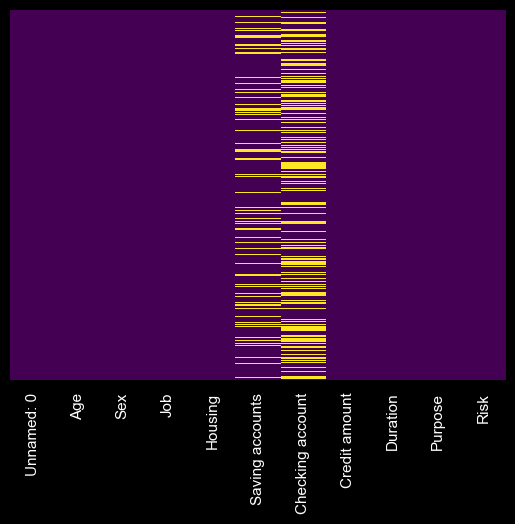

In [6]:
# Heatmap of dataframe's missing value mask
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')